In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics
from collections import defaultdict 

import matsim

In [2]:
## Adapted from Théo's code

def parse_attributes(node):
    values=[subnode.text for subnode in node.findall("attribute")]
    attributes=[subnode.attrib["name"] for subnode in node.findall("attribute")]
    person=dict()
    for ii in range(len(values)):
        person[attributes[ii]]=values[ii]
    if person!=[None]:
        return(person)
    
def parse_person(node):
    person = parse_attributes(node.find("attributes"))
    person["id"] = node.attrib["id"]
    return(person)

def parse_plan(node):
    children = list(node)
    plan={"selected":node.attrib["selected"]=="yes","activities":[{**{"activityType":child.tag}, **child.attrib} for child in children]}
    return plan

def parse_person_plan(node):
    # on récupère les plans sélectionnés
    plans = [parse_plan(plan) for plan in node.findall("plan") if plan.attrib["selected"]=="yes"]
    personId = node.attrib["id"]
    if len(plans)!=1:
        raise Exception("La personne d'id "+str(personId)+" a plusieurs plans sélectionnés !")
    else:
        plan={"personId":personId,"activities":plans[0]["activities"]}
        return(plan)

def parse_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person(node) for node in population.findall("person")]
    
def parse_plans_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person_plan(node) for node in population.findall("person")]

def select_first_coordinate_in_plan(person_plan):
    """A partir du plan d'une personne, remonte à ces premières coordonnées
    Renvoie un dict {personId,x,y}"""
    plan=person_plan["activities"]
    coordinates_found=False
    first_coordinates={"personId":person_plan["personId"]}
    for acti in plan:
        if "x" in acti:
            coordinates_found=True
            first_coordinates["x"]=acti["x"]
            first_coordinates["y"]=acti["y"]
            break
    if not coordinates_found:
        raise Exception("La personne "+str(person_plan["personId"])+" n'a pas de coordonnées définissables avec son plan d'activité.")
    else:
        return(first_coordinates)

def first_person_coordinates(path):
    with open(path, 'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        first_coordinates=[select_first_coordinate_in_plan(parse_person_plan(node)) for node in population.findall("person")]
        return(first_coordinates)

def population_stats(population):
    number=len(population)
    print("Taille population:   ",number)
    print("Titulaires du permis:",len([person for person in population if person["hasLicense"]=="yes"]))
    print("Femmes:              ",len([person for person in population if person["sex"]=="f"]))
    print("Hommes:              ",len([person for person in population if person["sex"]=="m"]))
    print("Revenu moyen:        ",statistics.mean([float(person["householdIncome"]) for person in population]))
    print("Abonnés aux pt:      ",len([person for person in population if person["hasPtSubscription"].lower()=="true"]))
    #return members
    #CSMembership(members,companies,CSMembership_file

In [3]:
def convert_time(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0])

def convert_time_h_m_s(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0, 1.0])

## Scenario description : Shared autonomous vehicle (SAV) => Robotaxis
- Remplacement des voitures privées des individus par des robotaxis non partagés. 
- Taille de la flotte de taxis $3869$ avec un taxi pour 10 voitures privées.
- Démotorisation (surpression de la voiture) des ménages résidant dans des zones denses (Lyon, Villeurbanne, Bron, Vaulx-en-Velin et Caluire-et-Cuire)
- Un passager par taxi

## Description de la population

- $\mathbf{5\%}$ de la population réelle ($\mathbf{30900}$ ménages /$\mathbf{63 110}$ ind. / $\mathbf{310 000}$ dép.)
- $\mathbf{27073}$ personnes pour $\mathbf{36787}$ déplacements en taxi.

## Configuration de la simulation

- $\mathbf{1300}$ itérations / simulation (arret de l'innovation à $\mathbf{80\%}$)
- Strategies de re-planification :
    - $\mathbf{5}$ plans max / agent
    - Chaque agent change, avec une probalité de $\mathbf{5\%}$, son itinéraire et le planning de ses activités (heure de fin). La probabilité du changement du mode de transport a été fixée à $\mathbf{10\%}$ pour accelerer la convergernce de la simulation.
    - Le changement de modes de transport pour les agents motorisés concerne uniquement les TC, le PAV, le vélo, et la marche à pied. Pour les agents non motorisés, le choix se fait entre les TC, le vélo, et la marche à pied.
    - Chaque agent choisi un plan parmi les 5 selon un modèle logit avec une probalité de $\mathbf{80\%}$.

## Analyse des resultats de la simulation

### Loading data

In [4]:
#output_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_calib2_TP_with_flow_cap_easing_300" 
output_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_1000_ite" 

In [5]:
##Case 1 : with 3869 taxis
task_time_profiles_taxi_file = "%s/ITERS/it.1300/sce2.1000_ite.1300.task_time_profiles_taxi.txt" %output_path
df_task_time_profiles_taxi = pd.read_csv(task_time_profiles_taxi_file, sep="	")

In [6]:
df_task_time_profiles_taxi

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY
0,00:00,0.0,0.0,0.0,0.0,3869.0
1,00:05,0.0,0.0,0.0,0.0,3869.0
2,00:10,0.0,0.0,0.0,0.0,3869.0
3,00:15,0.0,0.0,0.0,0.0,3869.0
4,00:20,0.0,0.0,0.0,0.0,3869.0
...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,0.0
357,29:45,0.0,0.0,0.0,0.0,0.0
358,29:50,0.0,0.0,0.0,0.0,0.0
359,29:55,0.0,0.0,0.0,0.0,0.0


In [7]:
df_task_time_profiles_taxi["time_in_s"] = df_task_time_profiles_taxi["time"].apply(convert_time).astype(float)

In [8]:
df_task_time_profiles_taxi

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY,time_in_s
0,00:00,0.0,0.0,0.0,0.0,3869.0,0.0
1,00:05,0.0,0.0,0.0,0.0,3869.0,300.0
2,00:10,0.0,0.0,0.0,0.0,3869.0,600.0
3,00:15,0.0,0.0,0.0,0.0,3869.0,900.0
4,00:20,0.0,0.0,0.0,0.0,3869.0,1200.0
...,...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,0.0,106800.0
357,29:45,0.0,0.0,0.0,0.0,0.0,107100.0
358,29:50,0.0,0.0,0.0,0.0,0.0,107400.0
359,29:55,0.0,0.0,0.0,0.0,0.0,107700.0


In [9]:
hours = ["00:00","01:00","02:00","03:00","04:00","05:00","06:00","07:00","08:00","09:00","10:00","11:00", 
        "12:00","13:00","14:00","15:00","16:00","17:00","18:00","19:00","20:00","21:00","22:00","23:00","24:00",
        "25:00","26:00","27:00","28:00","29:00","30:00"]

In [10]:
df_task_time_profiles_taxi["BUSY"] = df_task_time_profiles_taxi["PICKUP"] + df_task_time_profiles_taxi["DROPOFF"] + df_task_time_profiles_taxi["EMPTY_DRIVE"] + df_task_time_profiles_taxi["OCCUPIED_DRIVE"]

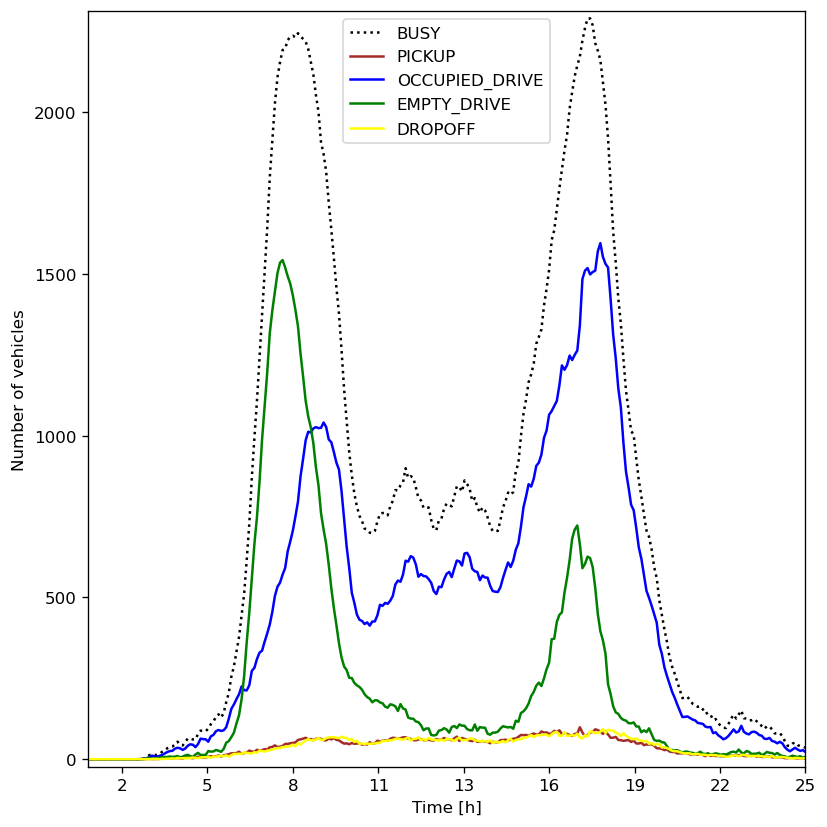

Fig. 1: Vehicle operations and open requests over the whole day with 3869 taxis


In [11]:
plt.figure(figsize = (7, 7), dpi = 120)

'''
for col in df_task_time_profiles_taxi.columns:
    if (str(col) == "time") or (str(col) == "time_h") or (str(col) == "time_in_s") :
        print("")
    
    else :
        plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi[col], color = (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()), label = col)#, linestyle = ":")

'''
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["BUSY"], color = "black", label = "BUSY" , linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["PICKUP"], color = "brown", label = "PICKUP")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["DROPOFF"], color = "yellow", label = "DROPOFF")#, linestyle = ":")

plt.xlabel("Time [h]")
plt.ylabel("Number of vehicles")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/task_time_profiles_Line_taxi_c2.pdf')
plt.close()
print("Fig. 1: Vehicle operations and open requests over the whole day with 3869 taxis")

In [12]:
print("Nombre maxi de taxis utilisés : ", int(max(df_task_time_profiles_taxi["BUSY"])))
print("Soit ", max(df_task_time_profiles_taxi["BUSY"])/3869 * 100, "% de la flotte.")

Nombre maxi de taxis utilisés :  2288
Soit  59.15533729645903 % de la flotte.


In [13]:
##Case 1 : with 3869 taxis

**Analyses**


La figure *Fig. 1* donne un aperçu la dynamique de répartition des taxis au cours de la journée pour une fotte de 3869 vehicules (taxis) :
- les véhicules roulant à vide vers les clients sont en vert, 
- ceux entrain de prendre des clients en marron, 
- en bleu, ce sont les taxis roulant avec des clients à bord
- les taxis déposant des clients sont en jaune
- ils totalisent tous le nombre de véhicules actuellement occupés (pointillés noirs)
- le nombre de demandes actuellement non planifiées (aucun véhicule n'a été envoyé vers elles) est indiqué en orange.

La figure illustre bien pics d'uttilisation des taxis durant les heures de pointes du matin (7h30h-9h) et du soir (17h-19h). 
On note une utilisation de **$75\%$** de la flotte pendant le pic du matin. Une grande partie de la flotte est donc mobilisée pour statisfaire la demande à cette periode.

Durant la pointe de l'après-midi, on observe une dimunition de nombre total de la flotte (moins de **$50\%$**). Cette baisse peut s'expliquer la reduction des distances à parcourir pour les trajets à vide sont. Cette situation est due probablement aux déplacments professionnels où les taxis sont utilisés le matin et parckés à proximité du lieu de travail.

## Daily statistics of taxis after the 1300th iteration

### Passenger Wait Time [s]

In [14]:
passenger_wait_time_file = "%s/ITERS/it.1300/passenger_wait_time.txt" %output_path

In [15]:
df_passenger_wait_time = pd.read_csv(passenger_wait_time_file, sep="	")

In [16]:
df_passenger_wait_time

,hour,n,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,27,"187,9","88,2",NaN,41,41,41,130,177,243,377,401,401
4,4,191,"157,2","91,5",NaN,2,2,6,97,144,212,345,376,449
5,5,428,"158,2","97,6",NaN,2,19,37,91,144,199,342,482,590
6,6,1551,"761,1","1003,5",NaN,2,25,59,185,399,832,2959,4355,6698
7,7,2980,"2403,1","2691,2",NaN,2,71,270,746,1361,2899,8886,11845,14580
8,8,2776,"1117,7","1958,8",NaN,2,2,2,350,687,1217,2456,12619,14164
9,9,2952,"372,9","987,2",NaN,2,2,2,57,185,414,1120,1635,13359


In [17]:
df_passenger_wait_time.drop('Unnamed: 4', inplace=True, axis=1)

In [18]:
df_passenger_wait_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    27 non-null     int64 
 1   n       27 non-null     int64 
 2   avg     27 non-null     object
 3   sd      27 non-null     object
 4   min     27 non-null     int64 
 5   2%ile   27 non-null     int64 
 6   5%ile   27 non-null     int64 
 7   25%ile  27 non-null     int64 
 8   50%ile  27 non-null     int64 
 9   75%ile  27 non-null     int64 
 10  95%ile  27 non-null     int64 
 11  98%ile  27 non-null     int64 
 12  max     27 non-null     int64 
dtypes: int64(11), object(2)
memory usage: 2.9+ KB


In [19]:
df_passenger_wait_time["avg"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["avg"]]
df_passenger_wait_time["sd"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["sd"]]

In [20]:
df_passenger_wait_time

,hour,n,avg,sd,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,27,187.9,88.2,41,41,41,130,177,243,377,401,401
4,4,191,157.2,91.5,2,2,6,97,144,212,345,376,449
5,5,428,158.2,97.6,2,19,37,91,144,199,342,482,590
6,6,1551,761.1,1003.5,2,25,59,185,399,832,2959,4355,6698
7,7,2980,2403.1,2691.2,2,71,270,746,1361,2899,8886,11845,14580
8,8,2776,1117.7,1958.8,2,2,2,350,687,1217,2456,12619,14164
9,9,2952,372.9,987.2,2,2,2,57,185,414,1120,1635,13359


In [21]:
df_passenger_wait_time["avg"].unique()

array(['0', '187.9', '157.2', '158.2', '761.1', '2403.1', '1117.7',
       '372.9', '81.8', '84.9', '83.4', '92.7', '99.0', '108.2', '213.3',
       '465.8', '237.4', '119.4', '90.3', '80.3', '108.5', '130.9',
       '149.6', '106.4'], dtype=object)

In [22]:
df_passenger_wait_time["avg"] = df_passenger_wait_time["avg"].astype(float)

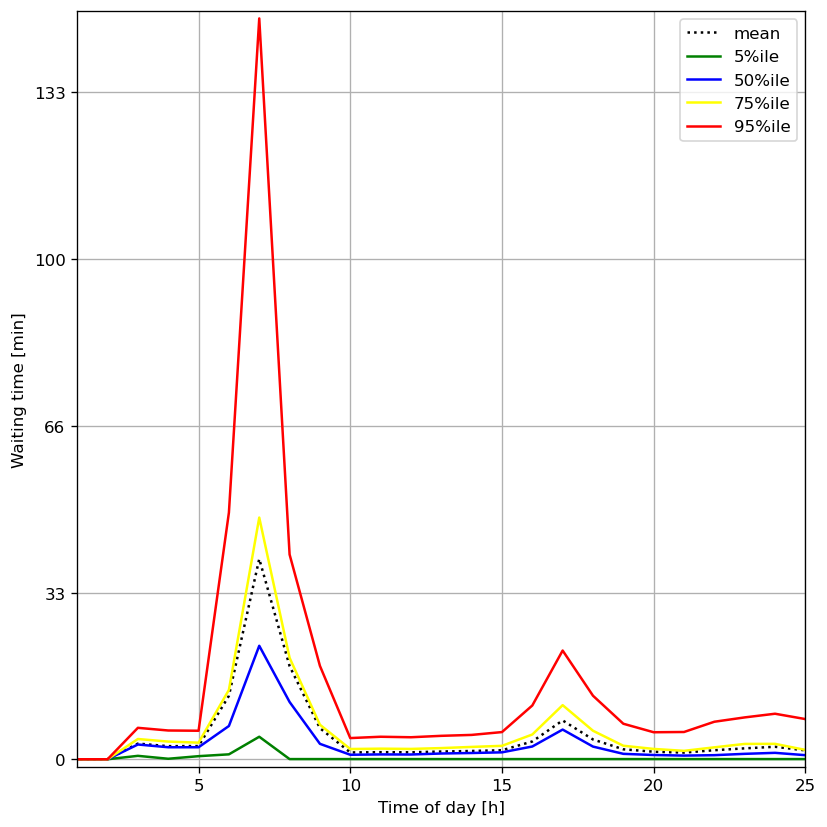

Fig. 2: Passenger wait times for each hour


In [23]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["75%ile"], color = "yellow", label = "75%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min]")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/passenger_wait_time_c2.pdf')
plt.close()
print("Fig. 2: Passenger wait times for each hour")

In [24]:
print("Max temp 95%ile d'attente ", max(df_passenger_wait_time["95%ile"])/60, " min")
print("Max temp 75%ile d'attente ", max(df_passenger_wait_time["75%ile"])/60, " min")
print("Max temp moyen d'attente ", max(df_passenger_wait_time["avg"])/60, " min")
print("Max temp median d'attente ", max(df_passenger_wait_time["50%ile"])/60, " min")
print("Max temp 5%ile d'attente ", max(df_passenger_wait_time["5%ile"])/60, " min")

Max temp 95%ile d'attente  148.1  min
Max temp 75%ile d'attente  48.31666666666667  min
Max temp moyen d'attente  40.05166666666666  min
Max temp median d'attente  22.683333333333334  min
Max temp 5%ile d'attente  4.5  min


**Analyses**


La figure *Fig. 2* les temps d'attente moyen (noir en pointillé), median (bleu), 5%ile (vert) et 95%ile (rouge) au cours de la journée pour une fotte de 3869 vehicules (taxis) :
- les temps d'attente moyens en dehors pic du matin matinal sont relativement faible (moins de 15 min). On note un maximal de 40 min durant les heures de pointes du matin. Le meme constat se fait pour les temps d'attente du 95e percentile où cette fois-ci le pic est de 2h30 d'attente. 
- le reste de la journée est assez stable avec des temps d'attente de moins de 3 min.

### Vehicle Empty Drive Ratio

In [25]:
vehicle_empty_drive_ratio_file = "%s/ITERS/it.1300/vehicle_empty_drive_ratio.txt" %output_path

In [26]:
df_vehicle_empty_drive_ratio = pd.read_csv(vehicle_empty_drive_ratio_file, sep="	")
df_vehicle_empty_drive_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,"0,2877","0,4355","0,3036",NaN,"0,027","0,027","0,051","0,246","0,343","0,606","1,000","1,000","1,000"
4,4,"0,2329","0,3067","0,2249",NaN,"0,000","0,000","0,038","0,171","0,242","0,384","0,867","1,000","1,000"
5,5,"0,2288","0,2826","0,2479",NaN,"0,000","0,000","0,000","0,123","0,215","0,356","1,000","1,000","1,000"
6,6,"0,4770","0,6154","0,3448",NaN,"0,000","0,000","0,070","0,314","0,563","1,000","1,000","1,000","1,000"
7,7,"0,7372","0,7839","0,2494",NaN,"0,000","0,215","0,331","0,588","0,896","1,000","1,000","1,000","1,000"
8,8,"0,6237","0,6144","0,2644",NaN,"0,000","0,085","0,200","0,413","0,598","0,830","1,000","1,000","1,000"
9,9,"0,3917","0,3427","0,2966",NaN,"0,000","0,000","0,000","0,109","0,277","0,484","1,000","1,000","1,000"


In [27]:
df_vehicle_empty_drive_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [28]:
df_vehicle_empty_drive_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["avg"]]
df_vehicle_empty_drive_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["sd"]]
df_vehicle_empty_drive_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["5%ile"]]
df_vehicle_empty_drive_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["50%ile"]]
df_vehicle_empty_drive_ratio["75%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["75%ile"]]
df_vehicle_empty_drive_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["95%ile"]]

df_vehicle_empty_drive_ratio["avg"] = df_vehicle_empty_drive_ratio["avg"].astype(float)
df_vehicle_empty_drive_ratio["5%ile"] = df_vehicle_empty_drive_ratio["5%ile"].astype(float)
df_vehicle_empty_drive_ratio["50%ile"] = df_vehicle_empty_drive_ratio["50%ile"].astype(float)
df_vehicle_empty_drive_ratio["75%ile"] = df_vehicle_empty_drive_ratio["75%ile"].astype(float)
df_vehicle_empty_drive_ratio["95%ile"] = df_vehicle_empty_drive_ratio["95%ile"].astype(float)

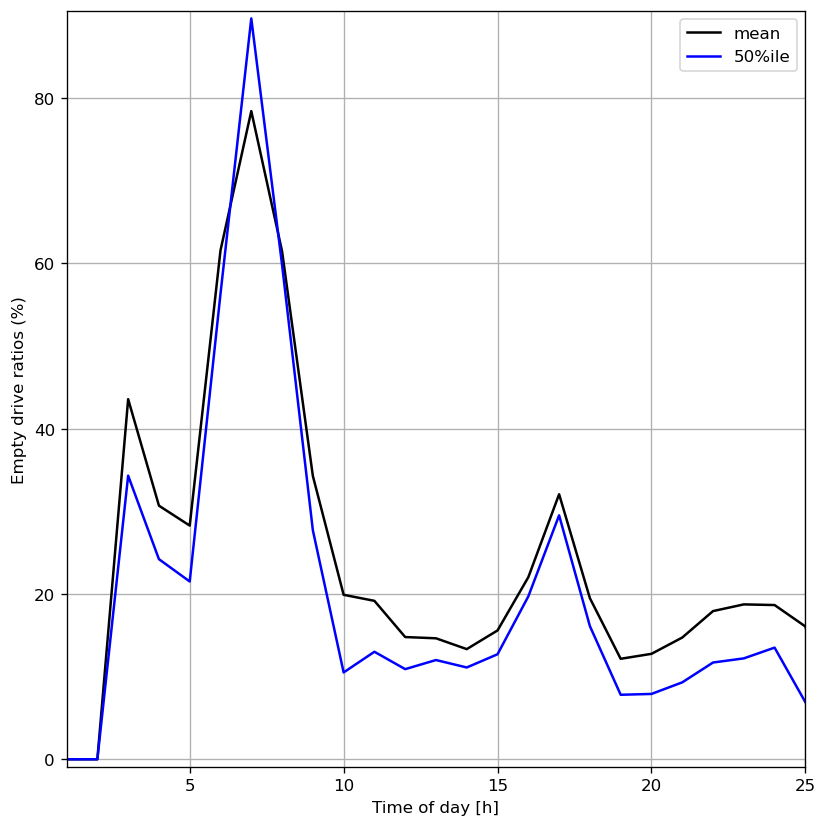

Fig. 3: Empty drive ratios for each hour


In [29]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["avg"], color = "black", label = "mean")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Empty drive ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/vehicle_empty_drive_ratio_c2.pdf')
plt.close()
print("Fig. 3: Empty drive ratios for each hour")

**Analyses**


La figure *Fig. 3*  renseigne sur le rapport entre le temps de conduite à vide et le temps total consacré à la conduite.
Durant le pic du matin (6h-8h), le ratio est très important avec près de $80\%$ de la flotte en moyenne qui circule à vide. 
Le reste de la journée, ce ratio diminue avec $30\%$ à 10h et moins de $20\%$ à la deuxieme moitié de la journée.

### Vehicle Wait Ratio

In [30]:
vehicle_wait_ratio_file = "%s/ITERS/it.1300/vehicle_wait_ratio.txt" %output_path
df_vehicle_wait_ratio = pd.read_csv(vehicle_wait_ratio_file, sep="	")
df_vehicle_wait_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
1,1,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
2,2,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
3,3,"0,9986","0,9986","0,0194",NaN,"0,559","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
4,4,"0,9896","0,9896","0,0605",NaN,"0,271","0,757","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
5,5,"0,9760","0,9760","0,0942",NaN,"0,149","0,591","0,762","1,000","1,000","1,000","1,000","1,000","1,000"
6,6,"0,9095","0,9095","0,2033",NaN,"0,028","0,222","0,381","1,000","1,000","1,000","1,000","1,000","1,000"
7,7,"0,5964","0,5964","0,4115",NaN,"0,000","0,000","0,001","0,157","0,691","1,000","1,000","1,000","1,000"
8,8,"0,4276","0,4276","0,4786",NaN,"0,000","0,000","0,000","0,002","0,034","1,000","1,000","1,000","1,000"
9,9,"0,5527","0,5527","0,4285",NaN,"0,000","0,000","0,000","0,089","0,551","1,000","1,000","1,000","1,000"


In [31]:
df_vehicle_wait_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [32]:
df_vehicle_wait_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["avg"]]
df_vehicle_wait_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["sd"]]
df_vehicle_wait_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["5%ile"]]
df_vehicle_wait_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["50%ile"]]
df_vehicle_wait_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["95%ile"]]

df_vehicle_wait_ratio["avg"] = df_vehicle_wait_ratio["avg"].astype(float)
df_vehicle_wait_ratio["5%ile"] = df_vehicle_wait_ratio["5%ile"].astype(float)
df_vehicle_wait_ratio["50%ile"] = df_vehicle_wait_ratio["50%ile"].astype(float)
df_vehicle_wait_ratio["95%ile"] = df_vehicle_wait_ratio["95%ile"].astype(float)

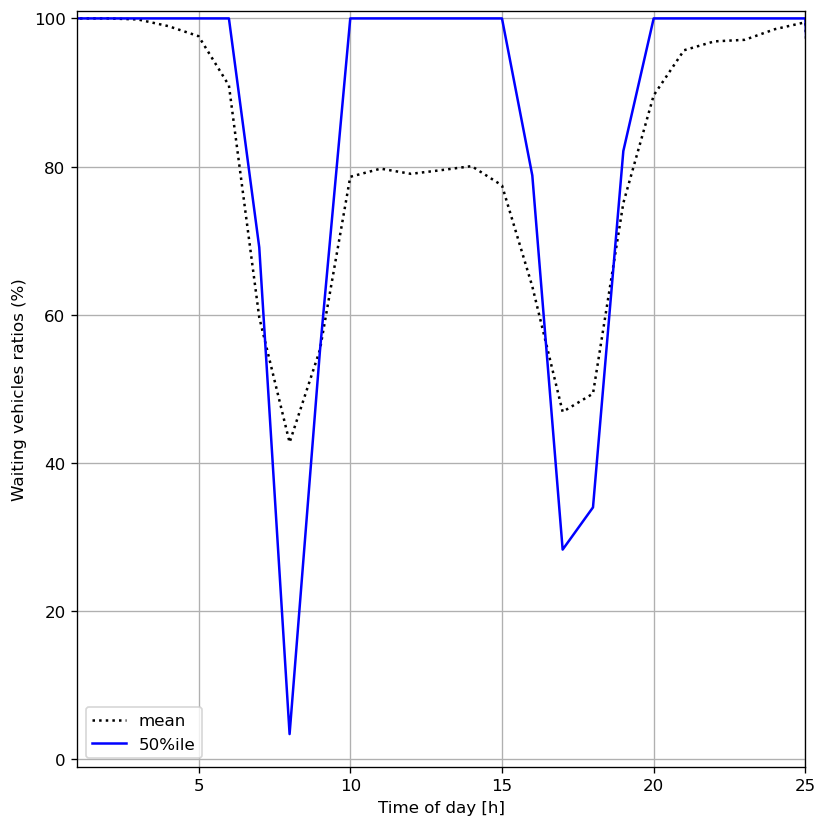

Fig. 4: Waiting vehicles ratios 


In [33]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["avg"], color = "black", label = "mean" , linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting vehicles ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/vehicle_wait_ratio_c2.pdf')
plt.close()
print("Fig. 4: Waiting vehicles ratios ")

### Total duration of tasks by type [h]

In [34]:
duration_of_tasks_by_type_file = "%s/ITERS/it.1300/duration_of_tasks_by_type.txt" %output_path
df_duration_of_tasks_by_type = pd.read_csv(duration_of_tasks_by_type_file, sep="	")
df_duration_of_tasks_by_type

,hour,EMPTY_DRIVE,PICKUP,OCCUPIED_DRIVE,DROPOFF,STAY,all
0,0,"0,00","0,00","0,00","0,00","3869,00","3869,00"
1,1,"0,00","0,00","0,00","0,00","3869,00","3869,00"
2,2,"0,00","0,00","0,00","0,00","3869,00","3869,00"
3,3,"1,36","0,40","3,37","0,25","3863,62","3869,00"
4,4,"8,13","3,07","26,78","2,34","3828,68","3869,00"
5,5,"18,30","6,95","61,68","6,08","3775,99","3869,00"
6,6,"151,41","17,69","166,01","14,86","3519,02","3869,00"
7,7,"1107,63","32,20","394,79","26,82","2307,56","3869,00"
8,8,"1317,36","55,24","794,75","47,21","1654,43","3869,00"
9,9,"628,75","60,77","976,50","64,63","2138,36","3869,00"


In [35]:
df_duration_of_tasks_by_type["EMPTY_DRIVE"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["EMPTY_DRIVE"]]
df_duration_of_tasks_by_type["PICKUP"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["PICKUP"]]
df_duration_of_tasks_by_type["OCCUPIED_DRIVE"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["OCCUPIED_DRIVE"]]
df_duration_of_tasks_by_type["DROPOFF"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["DROPOFF"]]
df_duration_of_tasks_by_type["STAY"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["STAY"]]

df_duration_of_tasks_by_type["EMPTY_DRIVE"] = df_duration_of_tasks_by_type["EMPTY_DRIVE"].astype(float)
df_duration_of_tasks_by_type["PICKUP"] = df_duration_of_tasks_by_type["PICKUP"].astype(float)
df_duration_of_tasks_by_type["OCCUPIED_DRIVE"] = df_duration_of_tasks_by_type["OCCUPIED_DRIVE"].astype(float)
df_duration_of_tasks_by_type["DROPOFF"] = df_duration_of_tasks_by_type["DROPOFF"].astype(float)
df_duration_of_tasks_by_type["STAY"] = df_duration_of_tasks_by_type["STAY"].astype(float)

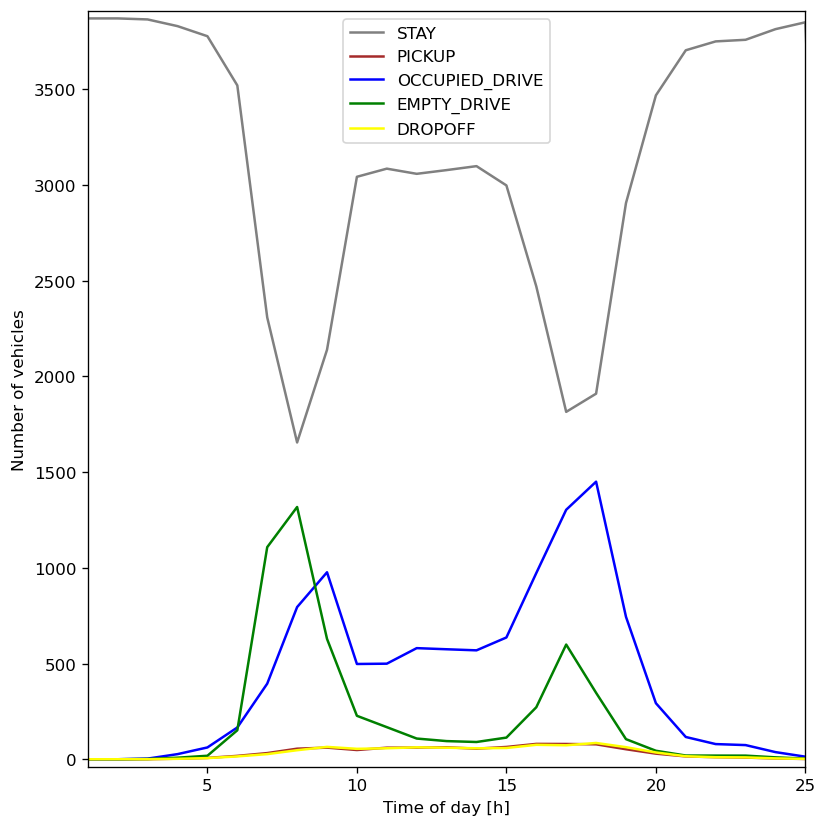

Fig. 5: Duration of task 


In [36]:
plt.figure(figsize = (7, 7), dpi = 120)

'''
for col in df_task_time_profiles_taxi.columns:
    if (str(col) == "time") or (str(col) == "time_h") or (str(col) == "time_in_s") :
        print("")
    
    else :
        plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi[col], color = (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()), label = col)#, linestyle = ":")

'''
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["STAY"], color = "gray", label = "STAY")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["PICKUP"], color = "brown", label = "PICKUP")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["DROPOFF"], color = "yellow", label = "DROPOFF")#, linestyle = ":")
plt.xlabel("Time of day [h]")
plt.ylabel("Number of vehicles")


#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/duration_of_tasks_by_type_c2.pdf')
plt.close()
print("Fig. 5: Duration of task ")

## Output events analysis

In [37]:
## Start analysis with 3 agents
output_path_3agents = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_3agents"
output_path_300 = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_calib2_TP_with_flow_cap_easing_300" 

In [38]:
#tree_events = ET.parse(gzip.open("%s/sce2.3agents.output_events.xml.gz" % output_path_3agents,'r'))

tree_events = ET.parse(gzip.open("%s/sce2.1000_ite.output_events.xml.gz" % output_path,'r'))
events  = tree_events.getroot()

In [39]:
events.tag, events.attrib

('events', {'version': '1.0'})

In [40]:
#events[0].tag, events[0].attrib

In [41]:
"""
for event in events.iter('event'):
    print(event.tag, event.attrib)
    #print(event[0])
    print(event.attrib["type"])
    break
"""

'\nfor event in events.iter(\'event\'):\n    print(event.tag, event.attrib)\n    #print(event[0])\n    print(event.attrib["type"])\n    break\n'

In [42]:
def events_stats(events):
    number=len(events)
    print("Number of events :   ",number)
    PassengerRequestSubmitted = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest submitted"])
    print("PassengerRequest submitted :", PassengerRequestSubmitted)
    PassengerRequestScheduled = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest scheduled"])
    print("PassengerRequest scheduled :", PassengerRequestScheduled)
    print("PassengerRequest not performed :", PassengerRequestSubmitted - PassengerRequestScheduled)
    pickupTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="PICKUP"])
    print("Number of pickup :", pickupTask)
    dropoffTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="DROPOFF"])
    print("Number of dropoff :", dropoffTask)
    occupiedDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="OCCUPIED_DRIVE"])
    print("Number of occupied driving :", occupiedDrive)
    emptyDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="EMPTY_DRIVE"])
    print("Number of empty driving :", emptyDrive)

In [43]:
#events_stats(events)

In [44]:
#rdvrpTaskStarted
time = []
person = []
link = []
dvrpVehicle = []
taskType = []

In [45]:
for event in events.iter('event'):
    if event.attrib["type"]=="dvrpTaskStarted":
        time.append(event.attrib["time"])
        person.append(event.attrib["person"])
        link.append(event.attrib["link"])
        dvrpVehicle.append(event.attrib["dvrpVehicle"])
        taskType.append(event.attrib["taskType"])

In [46]:
df_taskType = pd.DataFrame({"time":time, "person":person, "link": link, "dvrpVehicle" : dvrpVehicle, "taskType" : taskType})

df_taskType.to_csv("%s/df_taskType_taxi.csv" % output_path_300)

df_taskType_pick = df_taskType[df_taskType["taskType"]=="PICKUP"]

df_nb_pick_vh = df_taskType_pick.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

df_nb_pick_vh

,dvrpVehicle,number_of_pickups
0,TAX1001042,26
1,TAX1001085,25
2,TAX1001089,30
3,TAX1001439,34
4,TAX1001563,27
...,...,...
2738,TAXVIL113380,24
2739,TAXVIL113472,18
2740,TAXVIL113801,11
2741,TAXVIL11703,24


### VKT computation

In [48]:
import matsim

In [ ]:
#Author : Mathilde

class Events:
    
    def __init__(self, size, scenario):
        self.size = size
        self.scenario = scenario
        if size == '1p':            
            self.net = matsim.read_network('data/1percent/input_files/montreal_network.xml.gz')
            if scenario == 'base':
                self.file = 'data/1percent/output_1p/base/output_events.xml.gz'
                self.modes = ['all','car','bus','subway','other']
            elif scenario == 'sce1':
                self.file = 'data/1percent/output_1p/sce1/580/580.events.xml.gz'
                self.modes = ['all','pav','bus','subway','other']
            elif scenario == 'sce2':
                self.file = 'data/1percent/output_1p/sce2/540/540.events.xml.gz'
                self.modes = ['all','pav','bus','subway','taxi','other']
            elif scenario == 'sce3':
                self.file = 'data/1percent/output_1p/sce3/100/100.events.xml.gz'
                self.modes = ['all','pav','bus','subway','drt','other']
        elif size == '5p':
            self.net = matsim.read_network('data/1percent/input_files/montreal_network.xml.gz')
            if scenario == 'base':
                self.file = 'data/5percent/output_5p/base/output_events.xml.gz'
                self.modes = ['all','car','bus','subway','other']
            elif scenario == 'sce1':
                self.file = 'data/5percent/output_5p/sce1/260/260.events.xml.gz'
                self.modes = ['all','pav','bus','subway','other']
            elif scenario == 'sce2':
                self.file = 'data/5percent/output_5p/sce2/300/300.events.xml.gz'
                self.modes = ['all','pav','bus','subway','taxi','other']
            elif scenario == 'sce3':
                self.file = 'data/5percent/output_5p/sce3/60/60.events.xml.gz'
                self.modes = ['all','pav','bus','subway','drt','other']
        self.geo = self.net.as_geo()
        self.events = matsim.event_reader(self.file, types='left link')
        links = self.geo['link_id']
        self.link_counts = pd.DataFrame(index = links, columns=self.modes)
        print('Init done')

    def dico_to_dataframe(self, dico):
        dataframe = pd.DataFrame.from_dict(dico, orient='index', columns=['count']).rename_axis('link_id')
        dataframe = dataframe.merge(self.geo, on='link_id')
        dataframe = dataframe.assign(vkt = dataframe['count']*dataframe['length'])
        return(dataframe)

    def writeFile(self, vkt):
        vkt.to_csv('results/result_'+ self.size +'/TEST'+ self.scenario + '_vkt' '.csv',';') 
        print('File written')

    def vkt(self):
        events = self.events
        if self.scenario == 'base':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                else:
                    self.link_counts.at[event['link'],'car'] += 1
        elif self.scenario == 'sce1':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'taxi_' in event['vehicle']:
                    self.link_counts.at[event['link'],'pav'] += 1
                else:
                    self.link_counts.at[event['link'],'other'] += 1
        elif self.scenario == 'sce2':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'taxi_AV_' in event['vehicle']:
                    self.link_counts.at[event['link'],'taxi'] += 1
                elif 'taxi_' in event['vehicle']:
                    self.link_counts.at[event['link'],'pav'] += 1
                else:
                    self.link_counts.at[event['link'],'other'] += 1
        elif self.scenario == 'sce3':
            for event in events:
                self.link_counts.at[event['link'],'all'] += 1
                if 'bus' in event['vehicle']:
                    self.link_counts.at[event['link'],'bus'] += 1
                elif 'subway' in event['vehicle']:
                    self.link_counts.at[event['link'],'subway'] += 1
                elif 'drt' in event['vehicle']:
                    self.link_counts.at[event['link'],'drt'] += 1
                elif 'taxi_' in event['vehicle']:
                    self.link_counts.at[event['link'],'pav'] += 1
                else:
                    self.link_counts.at[event['link'],'other'] += 1
            print('couting done')   
            self.link_counts = self.link_counts.merge(self.geo, on='link_id') 
            print('merge done') 
            for mode in self.modes:
                self.link_counts[mode] = self.link_counts[mode]/self.link_counts['length']
            print('division done') 
            vkt = self.link_counts[self.modes].sum()
            self.writeFile(vkt)

def launch_analysis(size, scenario):
    events = Events(size, scenario)
    events.vkt()

In [49]:
matsim_events = matsim.event_reader("%s/sce2.1000_ite.output_events.xml.gz" % output_path, types='left link')

In [51]:
np.NaN + 1

nan

## Simulation Output trips cvs analysis

In [47]:
To do :
    - modal share

SyntaxError: invalid syntax (889902271.py, line 1)

In [ ]:
trips_file = "%s/sce2.1000_ite.output_trips.csv.gz" %output_path
df_trips_output = pd.read_csv(gzip.open(trips_file,'r'), sep=";")

In [ ]:
df_trips_output

In [ ]:
df_trips_output.info()

In [ ]:
df_trips_output.describe().transpose()

In [ ]:
df_trips_output["dep_time_in_s"] = df_trips_output["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["trav_time_in_s"] = df_trips_output["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["wait_time_in_s"] = df_trips_output["wait_time"].apply(convert_time_h_m_s).astype(float)

In [ ]:
df_trips_output

In [ ]:
time_class = np.arange(0, 30) * 3600

In [ ]:
time_class

In [ ]:
df_trips_output["dep_time_class"] = np.digitize(df_trips_output["dep_time_in_s"], time_class)

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Time [h]")

In [ ]:
df_trips_output_taxi = df_trips_output[df_trips_output["longest_distance_mode"]=="taxi"]
df_trips_output_taxi

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_taxi)
ax.grid(axis='y')
plt.ylabel("Taxi flow (output simulation)")
plt.xlabel("Time [h]")

In [ ]:
wait_time_class = [0, 300, 600, 900, 1800, 3600, np.inf]

In [ ]:
df_trips_output_taxi["wait_time_class"] = np.digitize(df_trips_output_taxi["wait_time_in_s"], wait_time_class)

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="wait_time_class", data=df_trips_output_taxi)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Waiting time [min]")

In [ ]:
#waiting mean time by time of day
df_wait_mean = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").mean().reset_index().rename({ "wait_time_in_s" : "avg" }, axis = 1)
#waiting median time by time of day
df_wait_median = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").median().reset_index().rename({ "wait_time_in_s" : "50%ile" }, axis = 1)
#waiting min time by time of day
df_wait_min = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").min().reset_index().rename({ "wait_time_in_s" : "min" }, axis = 1)
#waiting max time by time of day
df_wait_max = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").max().reset_index().rename({ "wait_time_in_s" : "max" }, axis = 1)
#waiting std time by time of day
df_wait_std = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").std().reset_index().rename({ "wait_time_in_s" : "std" }, axis = 1)

In [ ]:
#waiting 5% time by time of day
#percentile_5 = np.percentile(df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").value_counts, 5)

In [ ]:
df_wait_time = pd.merge(df_wait_mean, df_wait_median, on = "dep_time_class")

In [ ]:
df_wait_time

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_wait_time["dep_time_class"], df_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_wait_time["dep_time_class"], df_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min] (from trips output)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/trips_ouput_passenger_wait_time_c2.pdf')
plt.close()
print("Fig. 6: Passenger wait times for each hour (from trips output)")

#### Plus de 30 min d'attente

In [ ]:
df_trips_output_taxi_wait_30 = df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 1800]

In [ ]:
df_trips_output_taxi_wait_30

#### Plus de 60 min d'attente

In [ ]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 3600]

#### Plus de 2h d'attente

In [ ]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 7200]

#### Plus de 3h d'attente

In [ ]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 10800]

To do :
    - 90 percentile de temps d'attente
    - Projection des déplacements en fonction des O/D

## Investigation des agents qui ont un temps d'attente trop important à partir des plans d'entrée/sortie (cas de la personne 100428 par exemple)

### Input MATSim synthetic population (plans)

In [ ]:
input_trips_file = "%s/df_trips_input_plans.csv" %output_path
input_persons_file = "%s/df_persons_input_perons.csv" %output_path
df_persons_input = pd.read_csv(input_persons_file)
df_trips_input = pd.read_csv(input_trips_file)

In [ ]:
df_persons_input

In [ ]:
df_trips_input

In [ ]:
df_count_trips = df_trips_input[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [ ]:
df_persons_input = pd.merge(df_persons_input, df_count_trips, on = "person_id", how = "left")

In [ ]:
df_persons_input

In [ ]:
df_persons_input.describe()

In [ ]:
df_trips_input["dep_time_in_s"] = df_trips_input["departure_time"].apply(convert_time_h_m_s).astype(float)

In [ ]:
df_trips_input["dep_time_class"] = np.digitize(df_trips_input["dep_time_in_s"], time_class)

In [ ]:
f_taxi = df_trips_input["mode"] == "taxi"

In [ ]:
df_trips_input_taxi = df_trips_input[f_taxi]

In [ ]:
df_trips_input_taxi

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input)
ax.grid(axis='y')
plt.ylabel("Number of trips (input population)")
plt.xlabel("Time of day [h]")

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input_taxi)
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Time of day [h]")

### MATSim simulation output plans

In [ ]:
output_trips_file = "%s/df_trips_simulation_output_plans.csv" %output_path
output_persons_file = "%s/df_persons_output_perons.csv" %output_path
df_persons_output_pln = pd.read_csv(output_persons_file)
df_trips_output_pln = pd.read_csv(output_trips_file)

In [ ]:
df_persons_output_pln

In [ ]:
df_trips_output_pln

In [ ]:
df_count_trips2 = df_trips_output_pln[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [ ]:
df_persons_output_pln = pd.merge(df_persons_output_pln, df_count_trips2, on = "person_id", how = "left")

In [ ]:
df_persons_output_pln

In [ ]:
df_persons_output_pln.describe()

In [ ]:
df_trips_output_pln["dep_time_in_s"] = df_trips_output_pln["departure_time"].apply(convert_time_h_m_s).astype(float)

In [ ]:
df_trips_output_pln["dep_time_class"] = np.digitize(df_trips_output_pln["dep_time_in_s"], time_class)

In [ ]:
f_taxi = df_trips_output_pln["mode"] == "taxi"

In [ ]:
df_trips_output_taxi_pln = df_trips_output_pln[f_taxi]

In [ ]:
df_trips_output_taxi_pln

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_pln)
ax.grid(axis='y')
plt.ylabel("Number of trips (simulation output plans)")
plt.xlabel("Time of day [h]")

In [ ]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_taxi_pln)
ax.grid(axis='y')
plt.ylabel("Taxi flow (simulation output plans)")
plt.xlabel("Time of day [h]")

**Quelques commentaires**
- Le nombre total de déplacements ($38314$) en taxi en sortie de la simulation n'a pas changé par rapport à la demande initiale malgré les changements de modes de transport possibles ! 
- La probabilité de $5%$ de changement modal n'est-elle pas suffisante pour effectuter cette innovation?

### Analyse du plan d'activités de la personne 100428

In [ ]:
df_persons_input_100428 = df_persons_input[df_persons_input["person_id"] == 100428]
df_persons_input_100428

In [ ]:
df_trips_input_100428 = df_trips_input[df_trips_input["person_id"] == 100428]
df_trips_output_pln_100428 = df_trips_output_pln[df_trips_output_pln["person_id"] == 100428]

In [ ]:
df_trips_input_100428.transpose()

In [ ]:
((849638.15 - 847256.77)**2 + (6517972.32 - 6517598.9)**2)**(0.5)

In [ ]:
df_trips_output_pln_100428.transpose()

In [ ]:
df_trips_output_taxi[df_trips_output_taxi["person"] == 100428].transpose()

In [ ]:
df_taxi_trips_100428 = df_trips_output_taxi[df_trips_output_taxi["person"] == 100428]

In [ ]:
## Ville O/D des déplacements de l'agent 100428

In [ ]:
data_path = "/media/aodiallo/Data/MATSIM/data"
SOURCE = "edgt_lyon_2015/zf_lyon/ZF_Lyon_Metropolis.shp"

In [ ]:
df_iris = gpd.read_file("%s/%s" % (data_path, SOURCE))[[
        "codeiris", "commune", "insee", "geometry"
    ]].rename(columns = {
        "codeiris": "iris_id",
        "commune": "commune_name",
        "insee": "commune_id"
    })

df_iris.crs = "EPSG:2154"

df_iris["iris_id"] = df_iris["iris_id"].astype(str).astype("category")
df_iris["commune_id"] = df_iris["commune_id"].astype(str).astype("category")
df_iris["commune_name"] = df_iris["commune_name"].astype(str).astype("category")

In [ ]:
df_iris

In [ ]:
df_iris.plot()

In [ ]:
def is_in_urban_area(df, x ,y):
    point = Point(849638.15,y)
    table = df.contains(point)
    for x in table:
        if x== True:
            return(True)
    return(False)

def commune_origin(df, x ,y):
    point = Point(x,y)
    table = df.contains(point)
    commune_name=""
    for i in range (len(table)):
        if table[i]== True:
            commune_name = df.loc[i, "commune_name"]
            break
    return commune_name

In [ ]:
urban_cities = ["69381", "69382", "69383", "69384", "69385", "69386", "69387", "69388", "69389", "69266", "69029", "69256", "69034"]

In [ ]:
df_iris_urban = df_iris[df_iris["commune_id"].isin(urban_cities)]

In [ ]:
df_iris_urban

In [ ]:
df_iris_urban.plot()

In [ ]:
point = Point(849638.15,6517972.32)
table = df_iris_urban.contains(point)

In [ ]:
table

In [ ]:
df_iris_urban = df_iris_urban.reset_index() 

In [ ]:
df_iris_urban

In [ ]:
commune_origin(df_iris_urban, 849638.15, 6517972.32)

In [ ]:
df_taxi_trips_100428["commune_ori"] = df_taxi_trips_100428.apply(lambda row: commune_origin(df_iris_urban, row.start_x, row.start_y), axis=1)

In [ ]:
df_taxi_trips_100428["commune_dest"] = df_taxi_trips_100428.apply(lambda row: commune_origin(df_iris_urban, row.end_x, row.end_y), axis=1)

In [ ]:
df_taxi_trips_100428.transpose()

In [ ]:
df_taxis = pd.read_csv("%s/df_taxis.csv" % output_path)

In [ ]:
df_taxis

In [ ]:
df_nb_taxis = df_taxis[["commune"]].groupby("commune").size().reset_index(name = "number_of_taxis")

In [ ]:
df_nb_taxis

In [ ]:
df_trips_input_taxi.info()

In [ ]:
df_trips_input_taxi["commune_ori"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.from_x, row.from_y), axis=1)

In [ ]:
df_trips_input_taxi["commune_dest"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.to_x, row.to_y), axis=1)

In [ ]:
df_nb_trips_taxi_commune_dest = df_trips_input_taxi[["commune_dest"]].groupby("commune_dest").size().reset_index(name = "number_of_trips_taxi")

In [ ]:
df_nb_trips_taxi_commune_dest

In [ ]:
df_nb_trips_taxi_commune_dest = df_trips_input_taxi[["commune_dest"]].groupby("commune_dest").size().reset_index(name = "number_of_trips_taxi")

**Quelques commentaires**
- L'agent 100428 n'a pu realiser l'activité (travail) dont le deplacement a été fait en taxi avec plus de 4h de temps d'attente avec un depart initial à 7h38. L'heure de fin de l'activité etant 11h38!  
- On note que le plan en sortie de la simulation n'a pas été modifié en consequence comparé au plan d'entrée intitial. 

In [ ]:
#for event in events:
#    if event.attrib["type"] == 'PassengerRequest scheduled':
#        print("PassengerRequest scheduled")

In [ ]:
'''
#requests Submitted
person_id_sub = []
request_id_sub = []
request_time_sub = []
mode_sub = []
from_link_id_sub = []
to_link_id_sub = []

#requests scheduled
person_id_sch = []
request_id_sch = []
request_time_sch = []
mode_sch = []
veh = []
pickup_time = []
'''

In [ ]:
'''
#requestsSubmit = defaultdict(int) # defaultdict creates a blank dict entry on first reference
#list_requestsSubmit = []

for event in events.iter('event'):
    if event.attrib["type"]=="PassengerRequest submitted":
        person_id_sub.append(event.attrib["person"])
        request_id_sub.append(event.attrib["request"])
        request_time_sub.append(event.attrib["time"])
        mode_sub.append(event.attrib["mode"])
        from_link_id_sub.append(event.attrib["fromLink"])
        to_link_id_sub.append(event.attrib["toLink"])
    
    if event.attrib["type"]=="PassengerRequest scheduled":
        person_id_sch.append(event.attrib["person"])
        request_id_sch.append(event.attrib["request"])
        request_time_sch.append(event.attrib["time"])
        mode_sch.append(event.attrib["mode"])
        veh.append(event.attrib["vehicle"])
        pickup_time.append(event.attrib["pickupTime"])
'''

In [ ]:
#df_req_sub = pd.DataFrame(list(zip(person_id_sub, request_id_sub, request_time_sub, mode_sub, from_link_id_sub, to_link_id_sub)), columns=['person_id', 'request_id', 'time_s_sub', 'mode_sub', 'from_link_id_sub', 'to_link_id_sub'])
#df_req_sch = pd.DataFrame(list(zip(person_id_sch, request_id_sch, request_time_sch, mode_sch, veh, pickup_time)), columns=['person_id', 'request_id', 'time_s_sch', 'mode_sch', 'vehicle_sch', 'pickup_time_sch'])

In [ ]:
#df_req_sub

In [ ]:
#df_req_sch

In [ ]:
#print("Nombre de requetes non programmées : ", len(df_req_sub) - len(df_req_sch))

In [ ]:
#df_req = pd.merge(df_req_sch, df_req_sub[["person_id", "request_id", "time_s_sub", "from_link_id_sub", "to_link_id_sub"]], on = ["person_id", "request_id"], how = "right")

In [ ]:
#df_req = pd.merge(df_req_sub, df_req_sch[["person_id", "pickup_time_sch"]], on = "person_id", how = "left")
#df_req = pd.merge(df_req_sch, df_req_sub[["person_id", "time_s_sub", "from_link_id_sub", "to_link_id_sub"]], on = ["person_id", ], how = "right")

In [ ]:
##Withdrawal of pickup time 60s
#df_req["wait_time"] = df_req["pickup_time_sch"].astype(float) - df_req["time_s_sch"].astype(float) - 60

In [ ]:
#df_req

In [ ]:
#f = df_req["wait_time"].isna()
#np.count_nonzero(f)

In [ ]:
#df_req_sched = df_req[~f]

In [ ]:
#df_req_sched

In [ ]:
#df_req_sched.describe().transpose()

In [ ]:
#df_req_sched["time_sch_class"] = np.digitize(df_req_sched["time_s_sch"].astype(float), time_class)

In [ ]:
#df_req_sched

In [ ]:
#waiting mean time by time of day
 #df_wait_ev_mean = df_req_sched[["time_sch_class", "wait_time"]].groupby("time_sch_class").mean().reset_index().rename({ "wait_time" : "avg" }, axis = 1)
#waiting median time by time of day
#df_wait_ev_median = df_req_sched[["time_sch_class", "wait_time"]].groupby("time_sch_class").median().reset_index().rename({ "wait_time" : "50%ile" }, axis = 1)
#waiting min time by time of day
#df_wait_ev_min = df_req_sched[["time_sch_class", "wait_time"]].groupby("time_sch_class").min().reset_index().rename({ "wait_time" : "min" }, axis = 1)
#waiting max time by time of day
#df_wait_ev_max = df_req_sched[["time_sch_class", "wait_time"]].groupby("time_sch_class").max().reset_index().rename({ "wait_time" : "max" }, axis = 1)
#waiting std time by time of day
#df_wait_ev_std = df_req_sched[["time_sch_class", "wait_time"]].groupby("time_sch_class").std().reset_index().rename({ "wait_time" : "std" }, axis = 1)

In [ ]:
#df_wait_time_ev = pd.merge(df_wait_ev_mean, df_wait_ev_median, on = "time_sch_class")

In [ ]:
'''
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_wait_time_ev["time_sch_class"], df_wait_time_ev["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_wait_time_ev["time_sch_class"], df_wait_time_ev["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min] (from events output)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/df_wait_time_events_file_c2.pdf')
plt.close()
print("Fig. 8: Passenger wait times for each hour")
'''

In [52]:
203135095.83/52503.26

3868.999674115474

In [53]:
21401180.76/5531.45

3869.0001283569413